In [1]:
# efficientNet 사용
import os
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


In [2]:
# 경로 확인
dataset_path = "../_preprocessed_datasets_del_aug_duplicate"
categories = ["blue_jellyfish", "barrel_jellyfish", "compass_jellyfish", 
              "lions_mane_jellyfish", "mauve_stinger_jellyfish", "Moon_jellyfish"]

for category in categories:
    category_path = os.path.join(dataset_path, category)
    print(f"Checking path: {category_path}")
    print("Exists:", os.path.exists(category_path))


Checking path: ../_preprocessed_datasets_del_aug_duplicate/blue_jellyfish
Exists: True
Checking path: ../_preprocessed_datasets_del_aug_duplicate/barrel_jellyfish
Exists: True
Checking path: ../_preprocessed_datasets_del_aug_duplicate/compass_jellyfish
Exists: True
Checking path: ../_preprocessed_datasets_del_aug_duplicate/lions_mane_jellyfish
Exists: True
Checking path: ../_preprocessed_datasets_del_aug_duplicate/mauve_stinger_jellyfish
Exists: True
Checking path: ../_preprocessed_datasets_del_aug_duplicate/Moon_jellyfish
Exists: True


In [3]:
# 데이터 경로 설정
dataset_path = "../_preprocessed_datasets_del_aug_duplicate"
categories = ["blue_jellyfish", "barrel_jellyfish", "compass_jellyfish", 
              "lions_mane_jellyfish", "mauve_stinger_jellyfish", "Moon_jellyfish"]

In [4]:
# 이미지 크기 및 하이퍼파라미터 설정
img_height, img_width = 224, 224
batch_size = 32

In [5]:
# 데이터셋 준비
def prepare_data(dataset_path, categories):
    filepaths, labels = [], []
    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        if os.path.exists(category_path):
            for file in os.listdir(category_path):
                if file.endswith(('jpg', 'jpeg', 'png')):
                    filepaths.append(os.path.join(category_path, file))
                    labels.append(label)
    return filepaths, labels

filepaths, labels = prepare_data(dataset_path, categories)

In [6]:
# Train/Test 분리
train_files, test_files, train_labels, test_labels = train_test_split(
    filepaths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Train/Validation 분리
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

In [7]:
# 숫자 라벨 -> 문자열 클래스 이름으로 변환
label_to_class = {idx: name for idx, name in enumerate(categories)}
train_labels = [label_to_class[label] for label in train_labels]
val_labels = [label_to_class[label] for label in val_labels]
test_labels = [label_to_class[label] for label in test_labels]

In [8]:
# DataFrame 생성
train_df = pd.DataFrame({'filename': train_files, 'class': train_labels})
val_df = pd.DataFrame({'filename': val_files, 'class': val_labels})
test_df = pd.DataFrame({'filename': test_files, 'class': test_labels})


In [9]:
# ImageDataGenerator로 데이터 준비
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, 
                                   width_shift_range=0.2, height_shift_range=0.2, 
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True)


val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# 데이터 생성
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename', y_col='class',
    target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename', y_col='class',
    target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_files, 'class': test_labels}),
    x_col='filename', y_col='class',
    target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical',
    shuffle=False
)

Found 960 validated image filenames belonging to 6 classes.
Found 240 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.


In [11]:
# EfficientNet 모델 정의
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = True  # 전체를 학습 가능하게 설정
# 특정 레이어까지만 학습 가능하게 제한할 수도 있음
for layer in base_model.layers[:150]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),  # 추가 레이어
    layers.Dense(256, activation='relu'),  # 추가 레이어
    layers.Dense(256, activation='relu'),  # 추가 레이어
    layers.Dropout(0.5),
    layers.Dense(len(categories), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
import tensorflow as tf

# GPU 사용 가능 여부 확인
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPU is available.")
    for i, gpu in enumerate(gpus):
        gpu_details = tf.config.experimental.get_device_details(gpu)  # GPU 상세 정보
        gpu_name = gpu_details.get('device_name', 'Unknown GPU')
        print(f"GPU {i}: {gpu_name}")
else:
    print("GPU is not available.")

# 장치 설정
device_name = "/GPU:0" if gpus else "/CPU:0"

# 특정 장치에서 실행
with tf.device(device_name):
    print(f"Using {device_name} for computations")


GPU is available.
GPU 0: Tesla T4
Using /GPU:0 for computations


In [13]:
# 학습률 스케줄러 함수 정의
def lr_scheduler(epoch, lr):
    # 예: 매 epoch마다 학습률을 0.9배로 감소
    return lr * 0.9

# LearningRateScheduler 콜백 생성
lr_callback = LearningRateScheduler(lr_scheduler)

In [14]:
# 모델 학습
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[lr_callback]  # 학습률 스케줄러 콜백 추가
)

Epoch 1/50
30/30 [==============================] - 29s 481ms/step - loss: 1.8129 - accuracy: 0.1635 - val_loss: 1.7959 - val_accuracy: 0.1667
Epoch 2/50
30/30 [==============================] - 12s 385ms/step - loss: 1.8020 - accuracy: 0.1854 - val_loss: 1.7946 - val_accuracy: 0.1667
Epoch 3/50
30/30 [==============================] - 12s 388ms/step - loss: 1.8055 - accuracy: 0.1625 - val_loss: 1.7962 - val_accuracy: 0.1500
Epoch 4/50
30/30 [==============================] - 12s 390ms/step - loss: 1.7925 - accuracy: 0.1969 - val_loss: 1.7989 - val_accuracy: 0.1667
Epoch 5/50
30/30 [==============================] - 12s 381ms/step - loss: 1.7981 - accuracy: 0.1719 - val_loss: 1.8015 - val_accuracy: 0.1667
Epoch 6/50
30/30 [==============================] - 12s 386ms/step - loss: 1.7970 - accuracy: 0.1698 - val_loss: 1.7960 - val_accuracy: 0.1667
Epoch 7/50
30/30 [==============================] - 12s 382ms/step - loss: 1.7931 - accuracy: 0.1844 - val_loss: 1.7949 - val_accuracy: 0.1667

In [15]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

10/10 [==============================] - 2s 176ms/step - loss: 1.7928 - accuracy: 0.1767
Test Accuracy: 17.67%


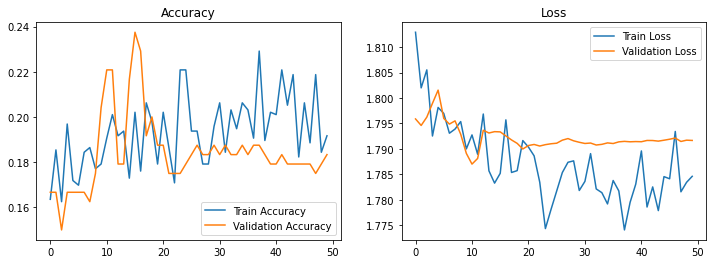

In [16]:
# 결과 시각화 (학습/검증 정확도, 손실)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()